In [171]:
from crim_intervals import *
import pandas as pd
import ast
import matplotlib
from itertools import tee, combinations
import numpy as np

In [172]:
# THIS IS DEV COPY for use with CLOSE/EXACT Matches

import numpy as np

# Converts lists to tuples

def lists_to_tuples_a(el):
    if isinstance(el, list):
        return tuple(el)
    else:
        return el

# Filters for the length of the Presentation Type in the Classifier

def limit_offset_size(array, limit):
    under_limit = np.cumsum(array) <= limit
    return array[: sum(under_limit)]

# Gets the the list of offset differences for each group 

def get_offset_difference_list_a(group):
    # if we do sort values as part of the func call, then we don't need this first line
    group = group.sort_values("start_offset")
    group["next_offset"] = group.start_offset.shift(-1)
    offset_difference_list = (group.next_offset - group.start_offset).dropna().tolist()
    return offset_difference_list

# The classifications are done here
# be sure to have the offset difference limit set here and matched in gap check below  80 = ten bars

def classify_offsets_a(offset_difference_list):
    """
    Put logic for classifying an offset list here
    """
    # 
    offset_difference_list = limit_offset_size(offset_difference_list, 500)
    
    alt_list = offset_difference_list[::2]
    
    if len(set(offset_difference_list)) == 1 and len(offset_difference_list) > 1:
        return ("PEN", offset_difference_list)
    # elif (len(offset_difference_list) %2 != 0) and (len(set(alt_list)) == 1):
    elif (len(offset_difference_list) %2 != 0) and (len(set(alt_list)) == 1) and (len(offset_difference_list) >= 3):
        return ("ID", offset_difference_list)
    elif len(offset_difference_list) >= 1:
        return ("Fuga", offset_difference_list)
    else: 
        return ("Singleton", offset_difference_list)
    
# adds predicted type, offsets and entry numbers to the results

def predict_type_a(group):
    offset_differences = get_offset_difference_list_a(group)
    predicted_type, offsets = classify_offsets_a(offset_differences)

    group["predicted_type"] = [predicted_type for i in range(len(group))]
    group["offset_diffs"] = [offsets for i in range(len(group))]
    group["entry_number"] = [i + 1 for i in range(len(group))]

    return group

In [173]:
# read CSV output of CRIM Intervals Search.

df = pd.read_csv(('A_Test_Files/Model_0001_Exact_4.csv'), index_col=0)
df = df.drop(columns=["ema", "ema_url", "end_measure", "end_beat"])
df.head()


,pattern_generating_match,pattern_matched,piece_title,part,start_measure,start_beat,start_offset,end_offset,note_durations
0,"(5, -2, 2, 3, -2, -2, -2)","[5, -2, 2, 3, -2, -2, -2]",Veni speciosam,Superius,1,1.0,0.0,21.0,"[4.0, 6.0, 2.0, 2.0, 2.0, 2.0, 3.0, 1.0]"
1,"(5, -2, 2, 3, -2, -2, -2)","[5, -2, 2, 3, -2, -2, -2]",Veni speciosam,Superius,10,1.0,72.0,94.0,"[4.0, 6.0, 2.0, 2.0, 2.0, 4.0, 2.0, 2.0]"
2,"(5, -2, 2, 3, -2, -2, -2)","[4, -2, 2, 3, -2, -2, -2]",Veni speciosam,Superius,35,2.0,274.0,292.0,"[4.0, 4.0, 2.0, 2.0, 2.0, 3.0, 1.0, 2.0]"
3,"(5, -2, 2, 3, -2, -2, -2)","[4, -2, 2, 3, -2, -2, -2]",Veni speciosam,Superius,125,1.0,1000.0,1013.0,"[2.0, 4.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0]"
4,"(5, -2, 2, 3, -2, -2, -2)","[4, -2, 2, 3, -2, -2, -2]",Veni speciosam,Contratenor,2,3.0,12.0,33.0,"[4.0, 6.0, 2.0, 2.0, 2.0, 2.0, 3.0, 1.0]"


In [174]:
# lists for views.  These are used when calling the df below

simple_view = ["piece_title", "part", "pattern_generating_match", "pattern_matched", "start_offset"]

offset_details = ["start_measure", "start_beat", "end_offset", "note_durations", "prev_entry_off", "next_entry_off"]

drop_cols = ["pattern_matched", "part", "pattern_generating_match", "piece_title", "start_measure", "start_beat", "end_offset", "note_durations", "prev_entry_off", "next_entry_off"]

ready_classify = ["pattern_generating_match", "pattern_matched", "piece_title", "part", "start_measure", "start_beat", "start_offset", "sub_group_id", "is_first"]

In [175]:
df['note_durations'] = df.note_durations.apply(ast.literal_eval)
df["sum_durs"] = df.note_durations.apply(sum)

In [255]:
# now process the original match data df by:
# sorting by start offset, then group by pattern generating match and applying the function above for prev entry
# also give each group a number
# sort by group number and start offset
# so that we can find PARALLEL (=0) Forward Gaps (the distance to NEXT entry), and Backward Gaps (distance to PREVIOUS Entry)
# All Proximate Matches are part of same sub Group (and go to classifier)
# Parallels are part of Sub Group but NOT part of Classified.  We will filter them OUT before classification
# Forward ONLY means the NEXT entry is a GAP.  No problem for Forward ONLY, since these are part of the previous set.
# Backward ONLY means the LAST entry was a GAP.  So these are NEW subgroups, since a new Presentation Type begins
# Forward AND Backward Gaps are SINGLETONS:  We will filter then OUT before Classification
# If an entry is the LAST in a Group and also has a BACKWARD gap it is also a SINGLETON

df2 = df
# df2 = df.sort_values("start_offset")

# Make Groups, Sort By Group and Offset, then and Add Previous/Next
df2["group_number"] = df2.groupby('pattern_generating_match').ngroup()
df2 = df2.sort_values(['group_number', 'start_offset'])
df2["prev_entry_off"] = df2["start_offset"].shift(1)
df2["next_entry_off"] = df2["start_offset"].shift(-1)


first_of_group = df2.drop_duplicates(subset=["pattern_generating_match"], keep='first').index
df2["is_first"] = df2.index.isin(first_of_group)
last_of_group = df2.drop_duplicates(subset=["pattern_generating_match"], keep='last').index
df2["is_last"] = df2.index.isin(last_of_group)

# Check Differences between Next and Last Offset

df2["last_off_diff"] = df2["start_offset"] - df2["prev_entry_off"]
df2["next_off_diff"] = df2["next_entry_off"] - df2["start_offset"]

# Find Parallel Entries 
df2["parallel"] = df2["last_off_diff"] == 0

# Set Gap Limits and Check Gaps Forward and Back
df2["forward_gapped"] = df2["next_off_diff"] >= 50
df2["back_gapped"] = df2["last_off_diff"] >= 50

# Find Singletons and Split Groups with Gaps
df2["singleton"] = ((df2['forward_gapped'] == True) & (df2['back_gapped'] == True) | (df2['back_gapped'] == True) & (df2["is_last"]))
df2["split_group"] = (df2['forward_gapped'] == False) & (df2['back_gapped'] == True)

#Mask Out Parallels and Singletons
df2 = df2[df2["parallel"] != True]
df2 = df2[df2["singleton"] != True]
df2["next_off_diff"] = df2["next_off_diff"].abs()
df2["last_off_diff"] = df2["last_off_diff"].abs()

# Find Final Groups
df2["combined_group"] = (df2.split_group | df2.is_first)
df2.loc[(df2["combined_group"]), "sub_group_id"] = range(df2.combined_group.sum())
df2["sub_group_id"] = df2["sub_group_id"].ffill()


# df2.head()


In [254]:
# mask out short soggetti

df2 = df2[df2["sum_durs"] >= 10]

# df2.head()

<AxesSubplot:>

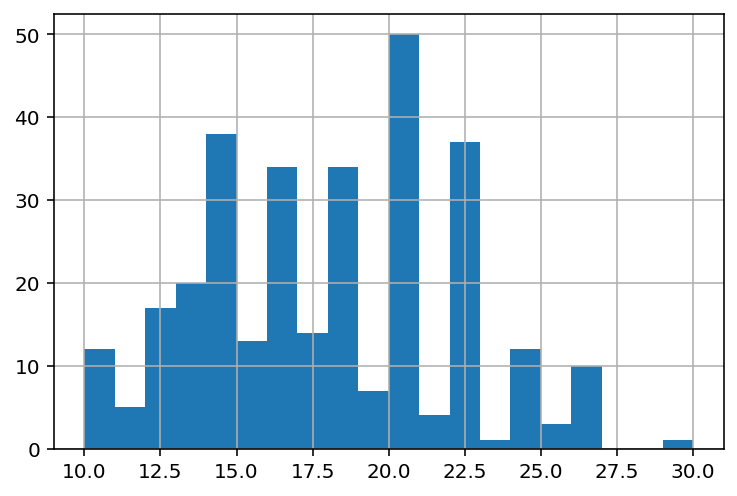

In [210]:
df2.sum_durs.hist(bins = 20)

In [211]:
# compact view for inspection of relevant columns

df3 = df2[ready_classify]
df3.shape

(312, 9)

In [285]:
# run the classifier on the newly curated list of groups

classified2 = df3.applymap(lists_to_tuples_a).groupby("sub_group_id").apply(predict_type_a)

# drop the new singletons

classified2.drop(classified2[classified2['predicted_type'] == "Singleton"].index, inplace = True)

# classified2 = classified2[classified2["predicted_type"] == "Fuga"]

classified2["start"] = classified2["start_measure"].astype(str) +"/"+ classified2["start_beat"].astype(str) 
c3 = classified2.drop(columns=['start_measure', 'start_beat','offset_diffs'])
# c3.head()


In [302]:
# put things back in order by offset and group them again
c4 = c3.sort_values(by = ["start_offset"])
c5 = c4.groupby(by = ["sub_group_id"])
c6 = c5.head(50)


In [314]:
# Now transform as Pivot Table
pivot_c6 = c6.pivot_table(index=["pattern_generating_match", "predicted_type", "sub_group_id"],
            columns="entry_number",
            values=["part", "start_offset", "start"],
            aggfunc=lambda x: x)
pivot_c6_sort = pivot_c6.sort_values(by = [("start_offset", 1)])
pivot_c6_sort = pivot_c6_sort.fillna("-")
pivot_c6_sort.head(10)


part  \
entry_number                                                     1    
pattern_generating_match   predicted_type sub_group_id                
(5, -2, 2, 3, -2, -2, -2)  Fuga           116.0            Superius   
(4, -2, 2, 3, -2, -2, -2)  Fuga           113.0            Superius   
(-2, 2, 2, -2, -2, -2, -3) Fuga           33.0             Superius   
(-2, 2, 3, -2, -2, -2, -2) Fuga           42.0             Superius   
(-2, 2, 3, -2, -2, -2, -3) ID             43.0             Superius   
(2, 3, -2, -2, -2, -2, 2)  ID             99.0             Superius   
(3, -2, -2, -2, -3, 2, 2)  ID             107.0            Superius   
(-3, 2, 3, -2, -2, -2, -2) Fuga           55.0             Superius   
(3, -2, -2, -2, -2, 2, 2)  Fuga           104.0         Contratenor   
(-2, 2, 2, -2, -2, -2, -2) Fuga           32.0               Bassus   

                                                                     \
entry_number                                                     2    
pattern_generating_match   predicted_type sub_group_id                
(5, -2, 2, 3, -2, -2, -2)  Fuga           116.0         Contratenor   
(4, -2, 2, 3, -2, -2, -2)  Fuga           113.0         Contratenor   
(-2, 2, 2, -2, -2, -2, -3) Fuga           33.0          Contratenor   
(-2, 2, 3, -2, -2, -2, -2) Fuga           42.0          Contratenor   
(-2, 2, 3, -2, -2, -2, -3) ID             43.0          Contratenor   
(2, 3, -2, -2, -2, -2, 2)  ID             99.0             Superius   
(3, -2, -2, -2, -3, 2, 2)  ID             107.0         Contratenor   
(-3, 2, 3, -2, -2, -2, -2) Fuga           55.0               Bassus   
(3, -2, -2, -2, -2, 2, 2)  Fuga           104.0              Bassus   
(-2, 2, 2, -2, -2, -2, -2) Fuga           32.0               Bassus   

                                                                     \
entry_number                                                     3    
pattern_generating_match   predicted_type sub_group_id                
(5, -2, 2, 3, -2, -2, -2)  Fuga           116.0         PrimusTenor   
(4, -2, 2, 3, -2, -2, -2)  Fuga           113.0         PrimusTenor   
(-2, 2, 2, -2, -2, -2, -3) Fuga           33.0          PrimusTenor   
(-2, 2, 3, -2, -2, -2, -2) Fuga           42.0             Superius   
(-2, 2, 3, -2, -2, -2, -3) ID             43.0          PrimusTenor   
(2, 3, -2, -2, -2, -2, 2)  ID             99.0          PrimusTenor   
(3, -2, -2, -2, -3, 2, 2)  ID             107.0         PrimusTenor   
(-3, 2, 3, -2, -2, -2, -2) Fuga           55.0               Bassus   
(3, -2, -2, -2, -2, 2, 2)  Fuga           104.0                   -   
(-2, 2, 2, -2, -2, -2, -2) Fuga           32.0                    -   

                                                                               \
entry_number                                                     4         5    
pattern_generating_match   predicted_type sub_group_id                          
(5, -2, 2, 3, -2, -2, -2)  Fuga           116.0              Bassus  Superius   
(4, -2, 2, 3, -2, -2, -2)  Fuga           113.0              Bassus  Superius   
(-2, 2, 2, -2, -2, -2, -3) Fuga           33.0                    -         -   
(-2, 2, 3, -2, -2, -2, -2) Fuga           42.0          PrimusTenor    Bassus   
(-2, 2, 3, -2, -2, -2, -3) ID             43.0               Bassus         -   
(2, 3, -2, -2, -2, -2, 2)  ID             99.0               Bassus         -   
(3, -2, -2, -2, -3, 2, 2)  ID             107.0              Bassus         -   
(-3, 2, 3, -2, -2, -2, -2) Fuga           55.0                    -         -   
(3, -2, -2, -2, -2, 2, 2)  Fuga           104.0                   -         -   
(-2, 2, 2, -2, -2, -2, -2) Fuga           32.0                    -         -   

                                                                       ...  \
entry_number                                           6  7  8  9  10  ...   
pattern_generating_match   predicted_type sub_group_id                 ...   
(5,

In [315]:
pivot_c6_sort.reset_index(inplace = True)
pivot_c6_sort.unstack(level=0)
# pivot_c6_sort

                          entry_number    
pattern_generating_match                0      (5, -2, 2, 3, -2, -2, -2)
                                        1      (4, -2, 2, 3, -2, -2, -2)
                                        2     (-2, 2, 2, -2, -2, -2, -3)
                                        3     (-2, 2, 3, -2, -2, -2, -2)
                                        4     (-2, 2, 3, -2, -2, -2, -3)
                                                         ...            
start_offset              10            75                             -
                                        76                             -
                                        77                             -
                                        78                             -
                                        79                             -
Length: 2640, dtype: object

In [316]:

pivot_c6_sort = pivot_c6_sort.drop(columns=['start_offset', "sub_group_id"])
pivot_c6_sort
# pivot_c6_sort["entry"] = pivot_c6_sort["entry_number"]
# abc = pivot_c6_sort["piece_title", "pattern_generating_match", "pattern_matched", "part", "group", "type"]
# abc

pattern_generating_match predicted_type         part  \
entry_number                                                        1   
0               (5, -2, 2, 3, -2, -2, -2)           Fuga     Superius   
1               (4, -2, 2, 3, -2, -2, -2)           Fuga     Superius   
2              (-2, 2, 2, -2, -2, -2, -3)           Fuga     Superius   
3              (-2, 2, 3, -2, -2, -2, -2)           Fuga     Superius   
4              (-2, 2, 3, -2, -2, -2, -3)             ID     Superius   
..                                    ...            ...          ...   
75               (-2, -2, -2, 2, 2, 2, 2)           Fuga       Bassus   
76               (-2, -2, -3, 2, 2, 2, 2)           Fuga       Bassus   
77               (-2, -3, 2, 2, 2, 2, -2)           Fuga       Bassus   
78              (-2, 2, 2, -2, -2, -2, 2)           Fuga  PrimusTenor   
79            (-2, -2, -2, 2, -2, -2, -2)           Fuga     Superius   

                                                                        ...  \
entry_number            2            3            4         5  6  7  8  ...   
0             Contratenor  PrimusTenor       Bassus  Superius  -  -  -  ...   
1             Contratenor  PrimusTenor       Bassus  Superius  -  -  -  ...   
2             Contratenor  PrimusTenor            -         -  -  -  -  ...   
3             Contratenor     Superius  PrimusTenor    Bassus  -  -  -  ...   
4             Contratenor  PrimusTenor       Bassus         -  -  -  -  ...   
..                    ...          ...          ...       ... .. .. ..  ...   
75            Contratenor            -            -         -  -  -  -  ...   
76            Contratenor            -            -         -  -  -  -  ...   
77            Contratenor            -            -         -  -  -  -  ...   
78               Superius            -            -         -  -  -  -  ...   
79               Superius            -            -         -  -  -  -  ...   

                 start                                                
entry_number         1        2      3      4       5  6  7  8  9 10  
0                1/1.0    2/3.0  5/1.0  6/3.0  10/1.0  -  -  -  -  -  
1                1/1.0    2/3.0  5/1.0  6/3.0  10/1.0  -  -  -  -  -  
2                1/3.0    3/1.0  5/3.0      -       -  -  -  -  -  -  
3                1/3.0    3/1.0  3/3.5  5/3.0   7/1.0  -  -  -  -  -  
4                1/3.0    3/1.0  5/3.0  7/1.0       -  -  -  -  -  -  
..                 ...      ...    ...    ...     ... .. .. .. .. ..  
75            109/2.75  111/1.0      -      -       -  -  -  -  -  -  
76            109/2.75  111/1.0      -      -       -  -  -  -  -  -  
77             109/3.0  111/2.0      -      -       -  -  -  -  -  -  
78             123/2.0  125/2.0      -      -       -  -  -  -  -  -  
79             126/2.0  126/4.0      -      -       -  -  -  -  -  -  

[80 rows x 22 columns]